In [1]:
import numpy as np
import pandas as pd
import os
import random
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
# JAKARTA
mobility = pd.read_csv('data/jakarta/mobility_maret_january.csv')
weather = pd.read_csv('data/jakarta/weather_maret_january.csv')
case = pd.read_csv('data/jakarta/case_maret_january.csv')

tanggal = case['date'].values
print(tanggal)

['2020-03-18' '2020-03-19' '2020-03-20' '2020-03-21' '2020-03-22'
 '2020-03-23' '2020-03-24' '2020-03-25' '2020-03-26' '2020-03-27'
 '2020-03-28' '2020-03-29' '2020-03-30' '2020-03-31' '2020-04-01'
 '2020-04-02' '2020-04-03' '2020-04-04' '2020-04-05' '2020-04-06'
 '2020-04-07' '2020-04-08' '2020-04-09' '2020-04-10' '2020-04-11'
 '2020-04-12' '2020-04-13' '2020-04-14' '2020-04-15' '2020-04-16'
 '2020-04-17' '2020-04-18' '2020-04-19' '2020-04-20' '2020-04-21'
 '2020-04-22' '2020-04-23' '2020-04-24' '2020-04-25' '2020-04-26'
 '2020-04-27' '2020-04-28' '2020-04-29' '2020-04-30' '2020-05-01'
 '2020-05-02' '2020-05-03' '2020-05-04' '2020-05-05' '2020-05-06'
 '2020-05-07' '2020-05-08' '2020-05-09' '2020-05-10' '2020-05-11'
 '2020-05-12' '2020-05-13' '2020-05-14' '2020-05-15' '2020-05-16'
 '2020-05-17' '2020-05-18' '2020-05-19' '2020-05-20' '2020-05-21'
 '2020-05-22' '2020-05-23' '2020-05-24' '2020-05-25' '2020-05-26'
 '2020-05-27' '2020-05-28' '2020-05-29' '2020-05-30' '2020-05-31'
 '2020-06-

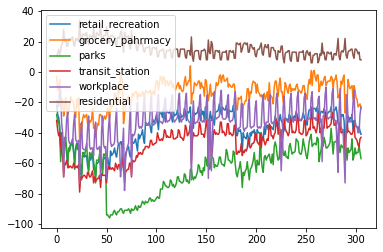

In [3]:
mobility.plot()
plt.show()

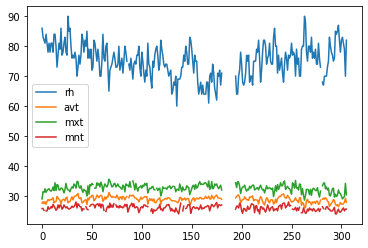

In [4]:
weather.plot()
plt.show()

In [5]:
print(case.shape)
case.head()

(306, 2)


,date,case
0,2020-03-18,158
1,2020-03-19,210
2,2020-03-20,215
3,2020-03-21,267
4,2020-03-22,307


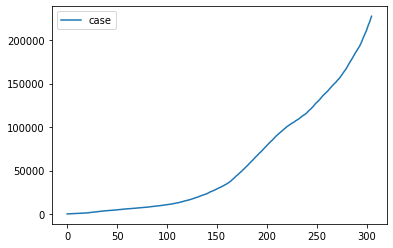

In [6]:
case.plot()
plt.show()

In [7]:
new_weather = weather.interpolate(method='spline', order=2)
new_weather.head()

,date,rh,avt,mxt,mnt
0,2020-03-18,86.0,27.6,29.0,25.800000
1,2020-03-19,83.0,28.1,31.4,25.800000
2,2020-03-20,82.0,27.4,31.2,25.200000
3,2020-03-21,81.0,28.1,32.4,26.132857
4,2020-03-22,84.0,27.2,31.2,25.000000


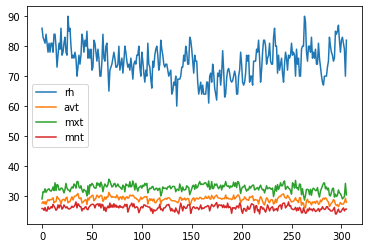

In [8]:
new_weather.plot()
plt.show()
#print(new_weather)

In [9]:
case.date = pd.to_datetime(case.date)

date = case['date'].values

case.set_index('date', inplace=True)

new_weather.date = pd.to_datetime(new_weather.date)
new_weather.set_index('date', inplace=True)

mobility.date = pd.to_datetime(mobility.date)
mobility.set_index('date', inplace=True)

In [10]:
df = pd.merge(case, new_weather, left_index=True, right_index=True)
df = pd.merge(df, mobility, left_index=True, right_index=True)
df.head()

,case,rh,avt,mxt,mnt,retail_recreation,grocery_pahrmacy,parks,transit_station,workplace,residential
date,,,,,,,,,,,
2020-03-18,158,86.0,27.6,29.0,25.800000,-22,-3,-28,-32,-19,11
2020-03-19,210,83.0,28.1,31.4,25.800000,-28,-12,-33,-38,-21,12
2020-03-20,215,82.0,27.4,31.2,25.200000,-30,-11,-32,-42,-23,15
2020-03-21,267,81.0,28.1,32.4,26.132857,-35,-5,-38,-40,-10,11
2020-03-22,307,84.0,27.2,31.2,25.000000,-49,-22,-59,-49,-12,14


In [11]:
df_external = pd.DataFrame(df.index)
df_external.head()

,date
0,2020-03-18
1,2020-03-19
2,2020-03-20
3,2020-03-21
4,2020-03-22


In [12]:
### ADJUST AND CLEAN DATA ###

for col in df.columns:
    
    if df[col].dtype == object: # correct type
        df[col] = pd.to_numeric(df[col].str.replace(',', '.'))
    
    df[col] = df[col].replace(-200, np.nan) # check nans
    print(col, ':', df[col].isna().sum()/len(df))
    if df[col][:int(len(df)*0.8)].isna().sum()/int(len(df)*0.8) > 0.5: # at least 50% in train not nan
        df.drop(col, axis=1, inplace=True)
    else:
        df[col] = df[col].interpolate(method='linear', limit_direction='both') # fill nans
    
    df_external[col] = df[col].values
    #df.drop(col, axis=1, inplace=True)

case : 0.0
rh : 0.0
avt : 0.0
mxt : 0.0
mnt : 0.0
retail_recreation : 0.0
grocery_pahrmacy : 0.0
parks : 0.0
transit_station : 0.0
workplace : 0.0
residential : 0.0


In [13]:
df_external.head()

,date,case,rh,avt,mxt,mnt,retail_recreation,grocery_pahrmacy,parks,transit_station,workplace,residential
0,2020-03-18,158,86.0,27.6,29.0,25.800000,-22,-3,-28,-32,-19,11
1,2020-03-19,210,83.0,28.1,31.4,25.800000,-28,-12,-33,-38,-21,12
2,2020-03-20,215,82.0,27.4,31.2,25.200000,-30,-11,-32,-42,-23,15
3,2020-03-21,267,81.0,28.1,32.4,26.132857,-35,-5,-38,-40,-10,11
4,2020-03-22,307,84.0,27.2,31.2,25.000000,-49,-22,-59,-49,-12,14


In [14]:
### UTILITY FUNCTION FOR CYCLICAL ENCODE VARIABLES ###

def cycle_encode(data, cols):
    
    for col in cols:
        
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
        
    return data

In [15]:
### BUILD DATAFRAME OF EXTERNAL VARIABLES ###

df_external['month'] = df_external.date.dt.month
df_external['day'] = df_external.date.dt.dayofweek

df_external = cycle_encode(df_external, ['month','day'])
df_external.drop(['month','day'], axis=1, inplace=True)
df_external.set_index('date', inplace=True)

print(df_external.shape)
df_external.head()

(306, 15)


,case,rh,avt,mxt,mnt,retail_recreation,grocery_pahrmacy,parks,transit_station,workplace,residential,month_sin,month_cos,day_sin,day_cos
date,,,,,,,,,,,,,,,
2020-03-18,158,86.0,27.6,29.0,25.800000,-22,-3,-28,-32,-19,11,1.0,6.123234e-17,8.660254e-01,-0.5
2020-03-19,210,83.0,28.1,31.4,25.800000,-28,-12,-33,-38,-21,12,1.0,6.123234e-17,1.224647e-16,-1.0
2020-03-20,215,82.0,27.4,31.2,25.200000,-30,-11,-32,-42,-23,15,1.0,6.123234e-17,-8.660254e-01,-0.5
2020-03-21,267,81.0,28.1,32.4,26.132857,-35,-5,-38,-40,-10,11,1.0,6.123234e-17,-8.660254e-01,0.5
2020-03-22,307,84.0,27.2,31.2,25.000000,-49,-22,-59,-49,-12,14,1.0,6.123234e-17,-2.449294e-16,1.0


In [16]:
df.head()

,case,rh,avt,mxt,mnt,retail_recreation,grocery_pahrmacy,parks,transit_station,workplace,residential
date,,,,,,,,,,,
2020-03-18,158,86.0,27.6,29.0,25.800000,-22,-3,-28,-32,-19,11
2020-03-19,210,83.0,28.1,31.4,25.800000,-28,-12,-33,-38,-21,12
2020-03-20,215,82.0,27.4,31.2,25.200000,-30,-11,-32,-42,-23,15
2020-03-21,267,81.0,28.1,32.4,26.132857,-35,-5,-38,-40,-10,11
2020-03-22,307,84.0,27.2,31.2,25.000000,-49,-22,-59,-49,-12,14


In [17]:
### SPLIT TRAIN TEST ###

train_date = tanggal[:int(len(df)*0.8)]
train = df[:int(len(df)*0.8)].copy()

test_date = tanggal[int(len(df)*0.8):]
test = df[int(len(df)*0.8):].copy()

print(train.shape, test.shape)

(244, 11) (62, 11)


In [18]:
### PLOTTING UTILITY FUNCTIONS ###

def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(train_date, train[name], label='train')
    plt.plot(test_date, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()
    
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))
    
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    
    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

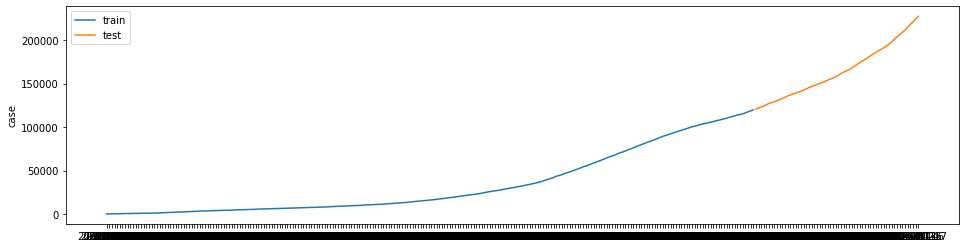

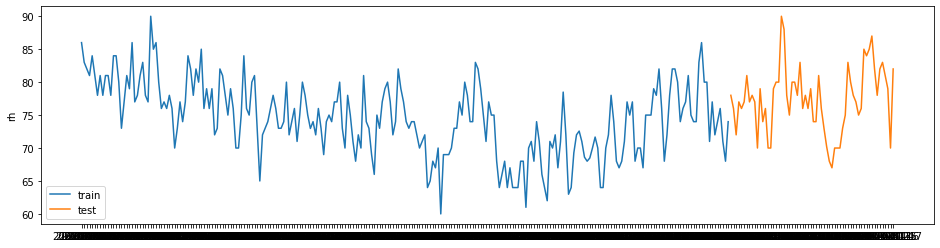

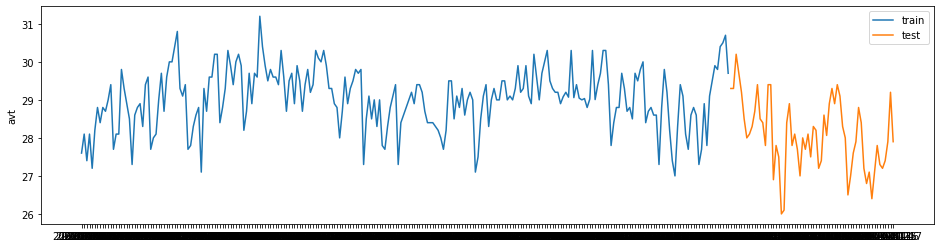

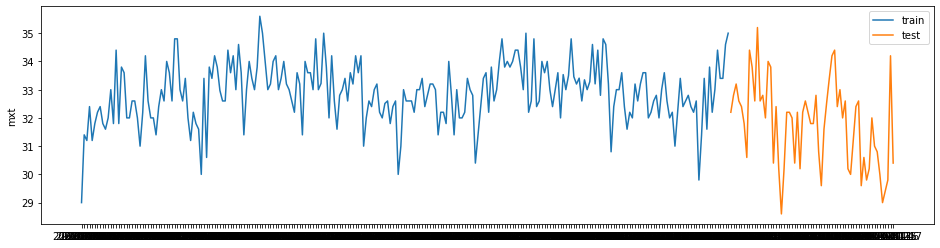

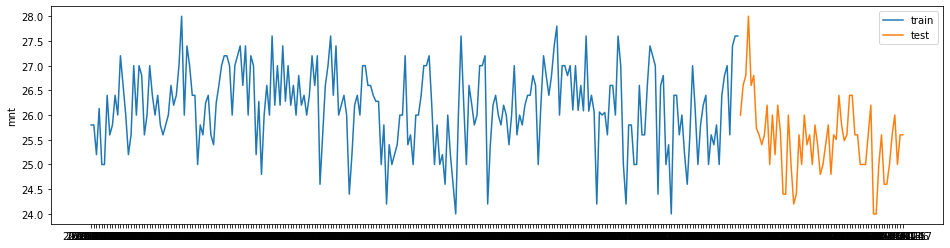

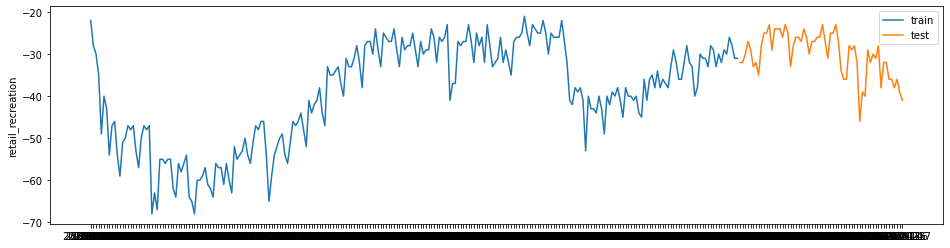

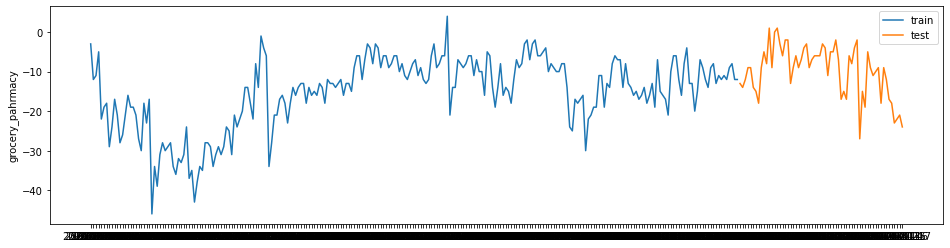

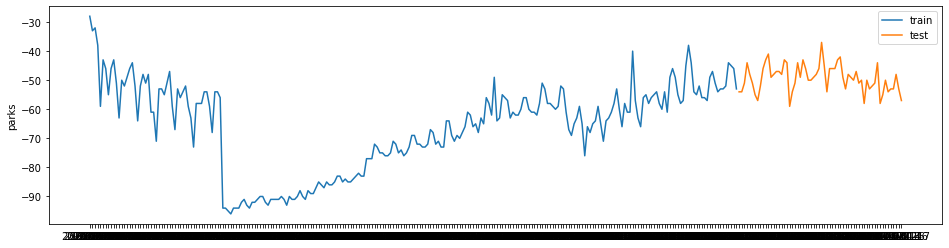

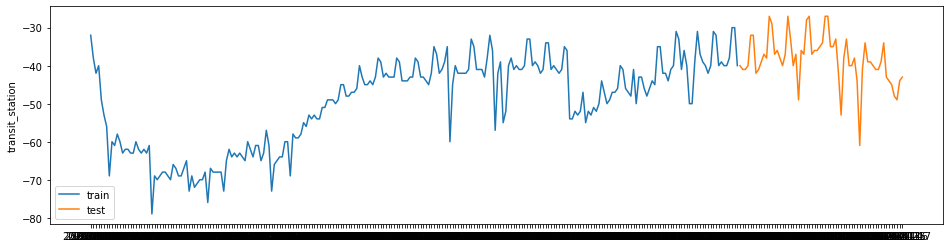

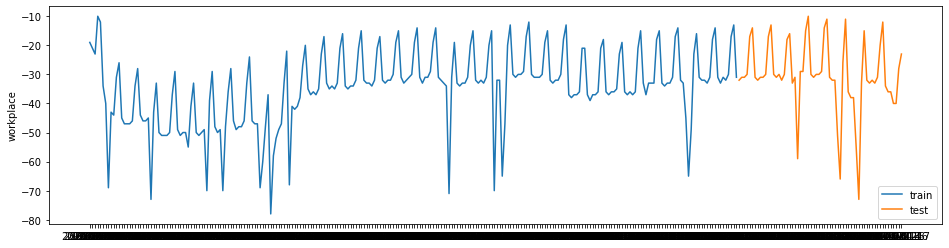

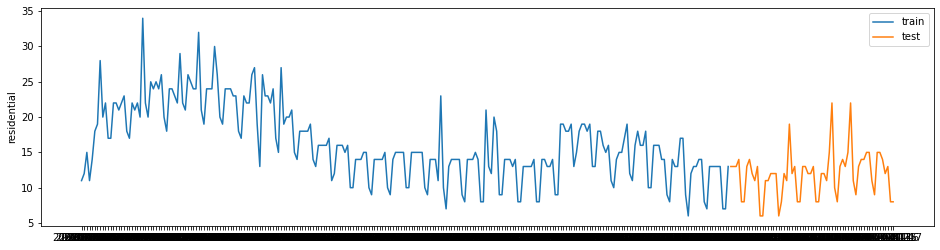

In [19]:
### PLOT ORIGINAL SERIES ###

for col in df.columns:
    plot_sensor(col)

C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


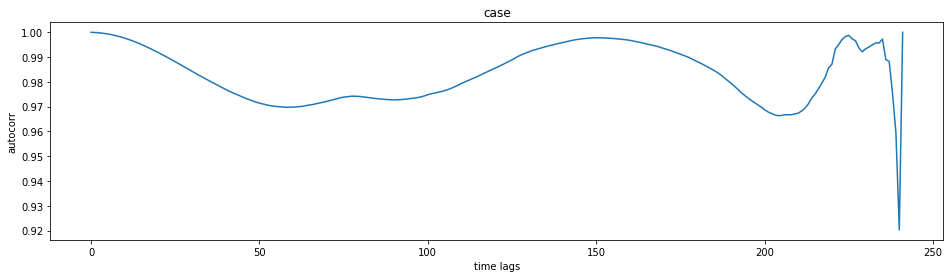

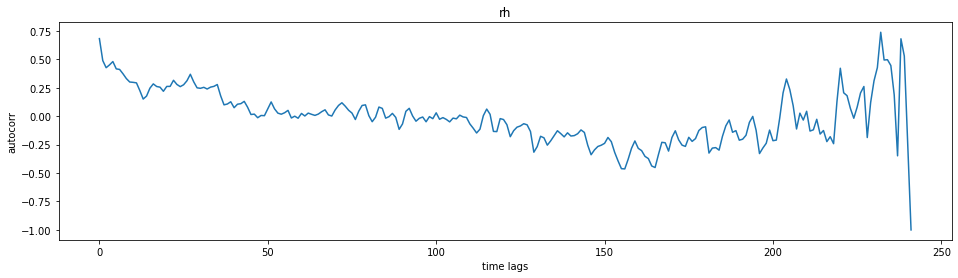

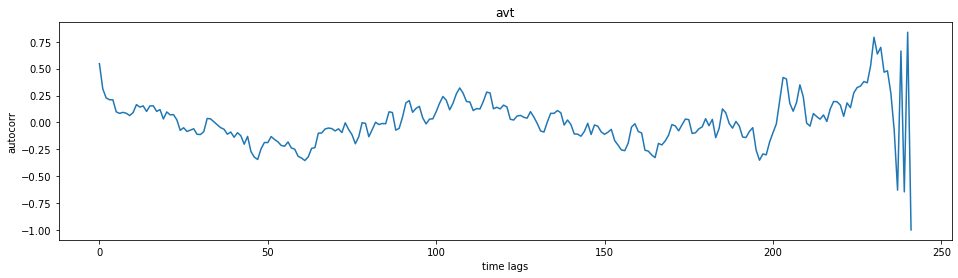

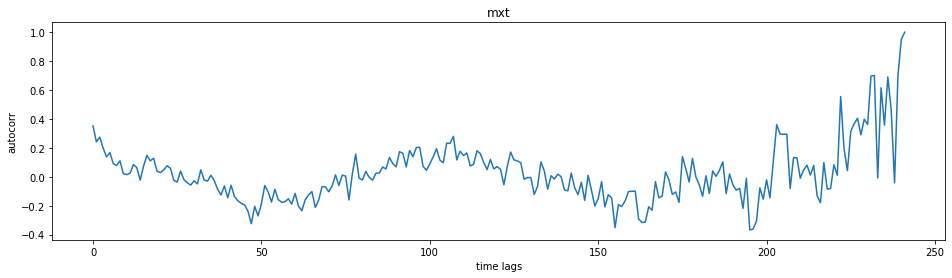

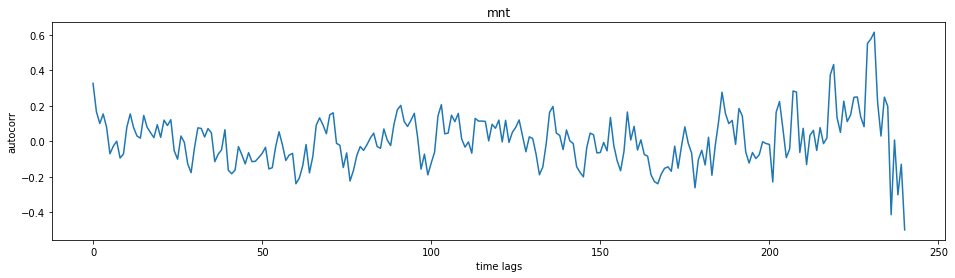

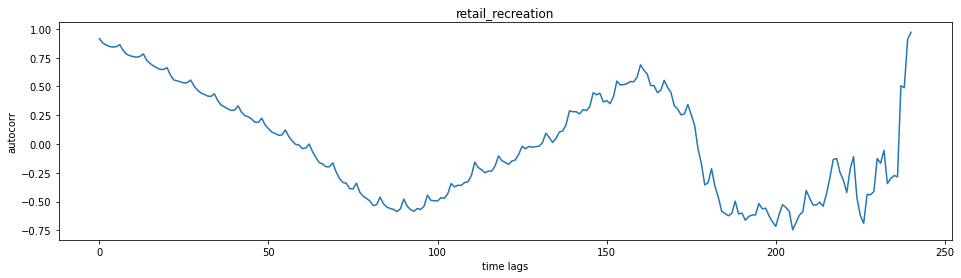

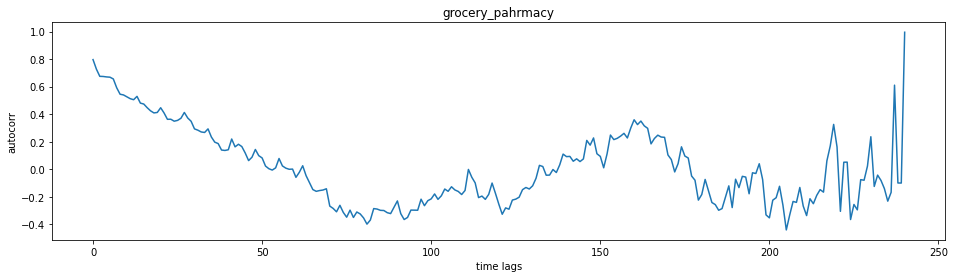

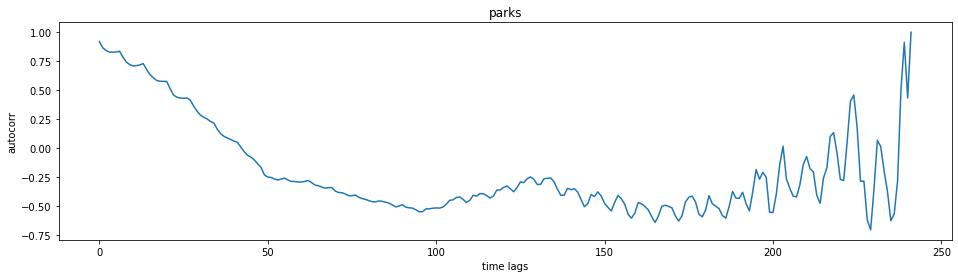

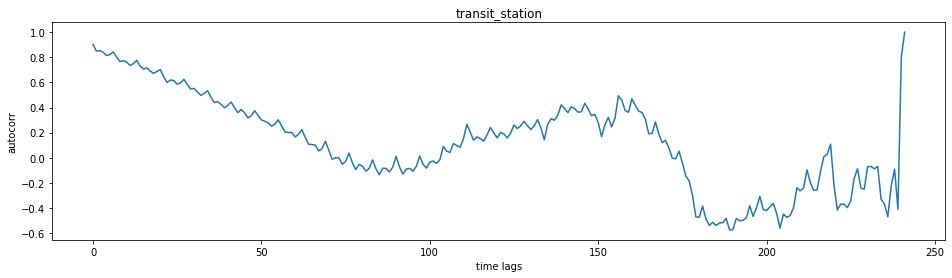

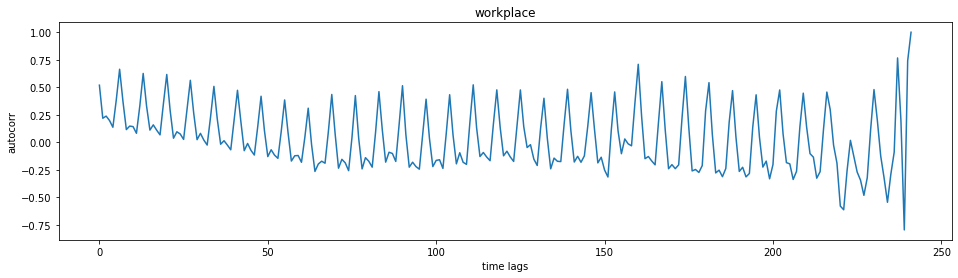

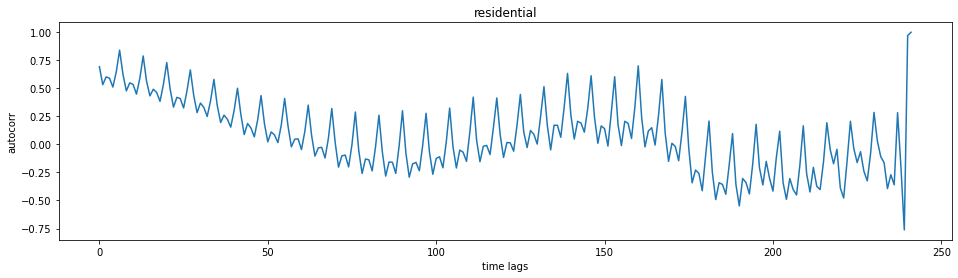

In [20]:
### PLOT AUTOCORRELATION ###

for col in df.columns:
    plot_autocor(col, train)

In [36]:
### OPERATE DIFFERENTIATION ###

period = 1

df_diff = df.diff(period).dropna()
df_external = df_external.iloc[period:].copy()

In [37]:
### SPLIT DIFFERENTIAL DATA IN TRAIN AND TEST ###

train_diff = df_diff.iloc[:len(train)-period,:].copy()
test_diff = df_diff.iloc[len(train)-period:,:].copy()

train_init = df.iloc[:len(train)-period,:].copy()
test_init = df.iloc[len(train)-period:-period,:].copy()

train_ext = df_external.iloc[:len(train)-period,:].copy()
test_ext = df_external.iloc[len(train)-period:,:].copy()

print(train_diff.shape, train_init.shape, train_ext.shape)
print(test_diff.shape, test_init.shape, test_ext.shape)

(243, 11) (243, 11) (137, 15)
(62, 11) (62, 11) (0, 15)


C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


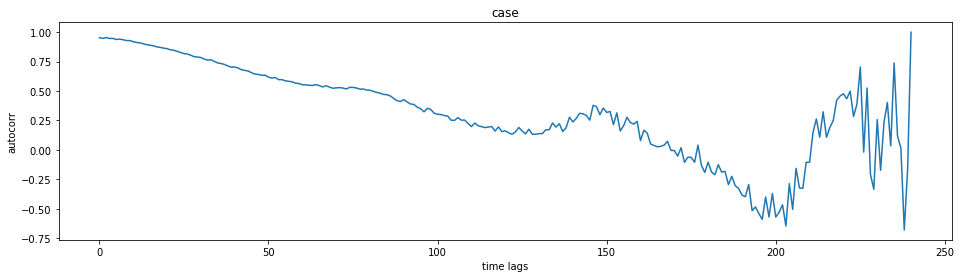

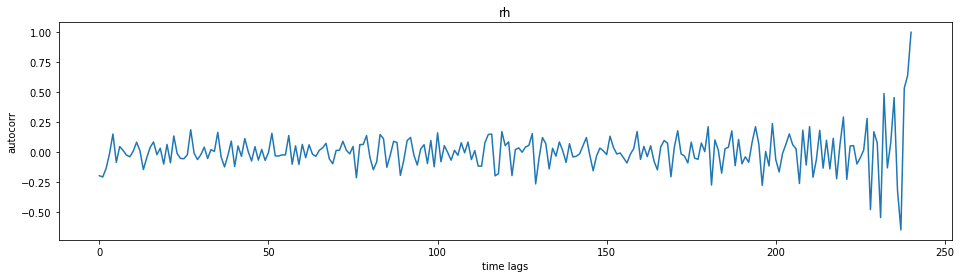

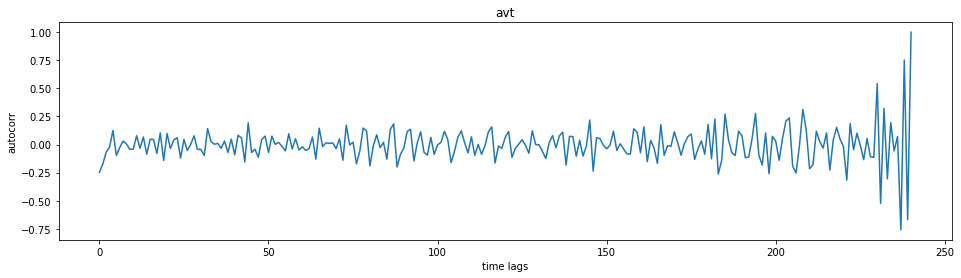

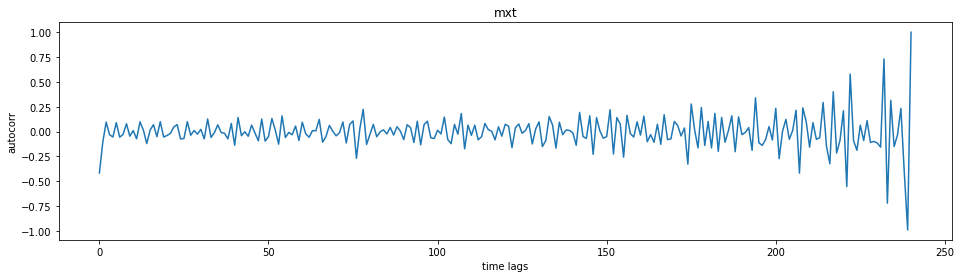

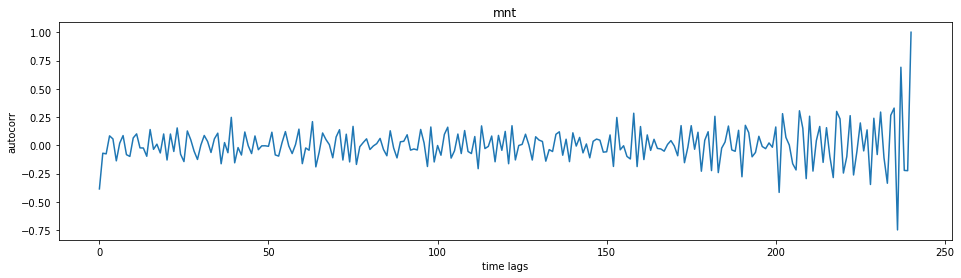

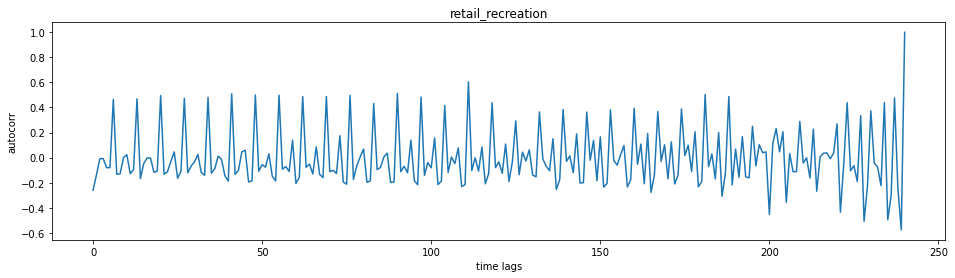

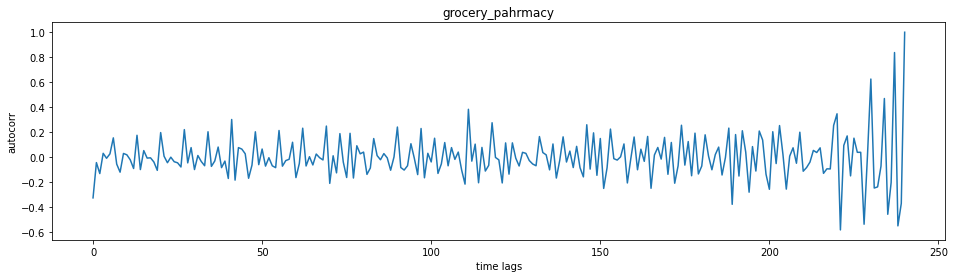

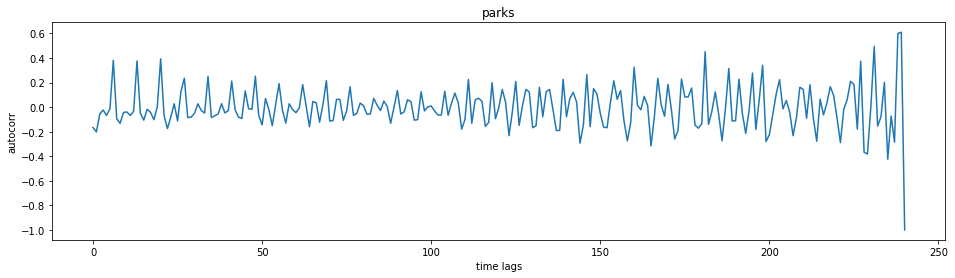

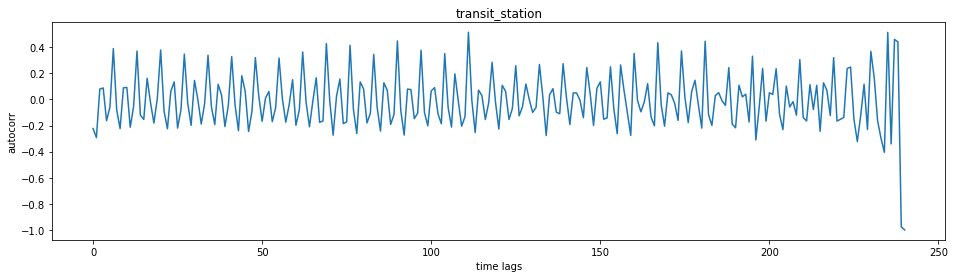

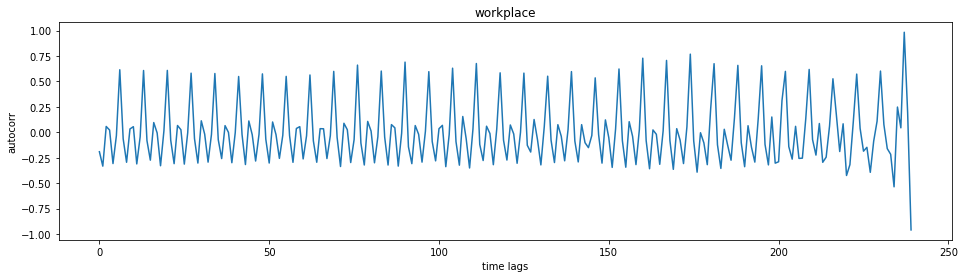

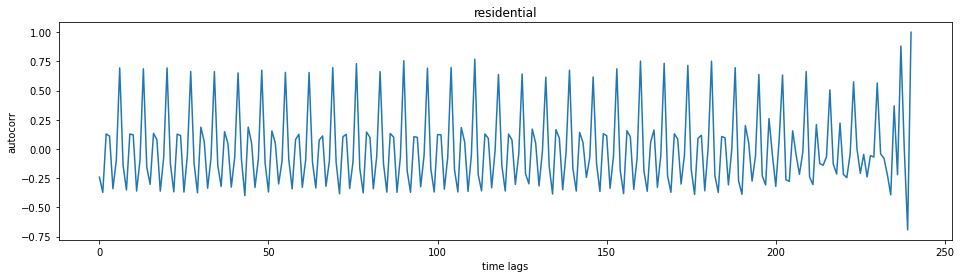

In [38]:
### PLOT DIFFERENTIAL SERIES ###

for col in df.columns:
    plot_autocor(col, train_diff)

In [39]:
train_diff

,case,rh,avt,mxt,mnt,retail_recreation,grocery_pahrmacy,parks,transit_station,workplace,residential
date,,,,,,,,,,,
2020-03-19,52.0,-3.0,0.5,2.4,0.000000,-6.0,-9.0,-5.0,-6.0,-2.0,1.0
2020-03-20,5.0,-1.0,-0.7,-0.2,-0.600000,-2.0,1.0,1.0,-4.0,-2.0,3.0
2020-03-21,52.0,-1.0,0.7,1.2,0.932857,-5.0,6.0,-6.0,2.0,13.0,-4.0
2020-03-22,40.0,3.0,-0.9,-1.2,-1.132857,-14.0,-17.0,-21.0,-9.0,-2.0,3.0
2020-03-23,46.0,-3.0,1.0,0.6,0.000000,9.0,3.0,16.0,-4.0,-22.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-12,831.0,2.0,-0.1,1.4,0.200000,-1.0,-1.0,1.0,0.0,-1.0,0.0
2020-11-13,1033.0,2.0,0.6,-1.0,-1.400000,4.0,3.0,8.0,2.0,2.0,0.0
2020-11-14,1255.0,-5.0,0.1,0.0,1.800000,-2.0,1.0,-1.0,8.0,13.0,-6.0


In [42]:
model = VAR(train_diff)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  25.030821521196554
BIC :  26.933878462736565
FPE :  74325279723.08347
HQIC:  25.79744124224675 

Lag Order = 2
AIC :  24.06332187815866
BIC :  27.721635671408187
FPE :  28402166370.265324
HQIC:  25.537188748987493 

Lag Order = 3
AIC :  23.734200746064392
BIC :  29.15819640160566
FPE :  20739488832.358265
HQIC:  25.919675000809118 

Lag Order = 4
AIC :  23.559725845246007
BIC :  30.759932783346834
FPE :  17930039025.28401
HQIC:  26.461211032892155 

Lag Order = 5
AIC :  22.854393983855402
BIC :  31.841447492181572
FPE :  9299507498.016924
HQIC:  26.476337554425236 

Lag Order = 6
AIC :  22.40054984670613
BIC :  33.18519256407572
FPE :  6368708074.567328
HQIC:  26.747443747391543 

Lag Order = 7
AIC :  22.253534515775648
BIC :  34.8466179425213
FPE :  6134077621.067836
HQIC:  27.329915797215914 

Lag Order = 8
AIC :  22.407116147645002
BIC :  36.81960218316471
FPE :  8334814429.9815855
HQIC:  28.21756758055429 

Lag Order = 9
AIC :  22.43796479247363
BIC :  38.68092

C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [43]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,28.74,28.91,3.038e+12,28.81
1,24.96,26.92*,6.909e+10,25.75
2,23.90,27.67,2.415e+10,25.42*
3,23.63,29.20,1.866e+10,25.87
4,23.62,31.00,1.916e+10,26.60
5,22.93,32.11,1.008e+10,26.63
6,22.44,33.42,6.694e+09*,26.87
7,22.41*,35.19,7.294e+09,27.56
8,22.52,37.11,9.583e+09,28.41
9,22.54,38.93,1.205e+10,29.15


In [45]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,12):
    model = VAR(endog=train_diff.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER 7 BEST AIC: 22.253534515775648


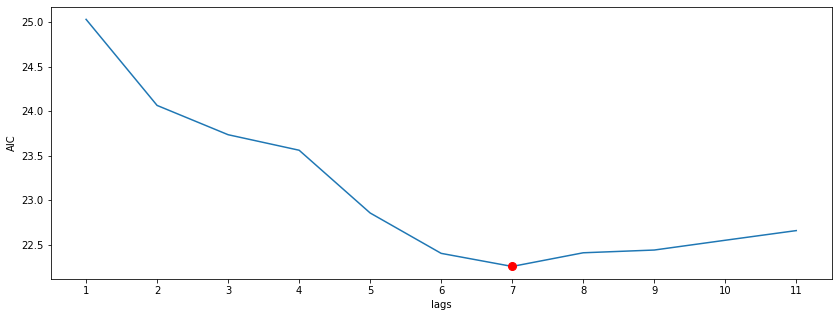

In [46]:
### PLOT AICs ### 

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,12))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [47]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###

var = VAR(endog=train_diff.values)
var_result = var.fit(maxlags=best_order)
var_result.aic

22.253534515775648

In [48]:
### UTILITY FUNCTION FOR RETRIVE VAR PREDICTIONS ###

def retrive_prediction(prior, prior_init, steps):
    
    pred = var_result.forecast(np.asarray(prior), steps=steps)
    init = prior_init.tail(period).values
    
    if steps > period:
        id_period = list(range(period))*(steps//period)
        id_period = id_period + list(range(steps-len(id_period)))
    else:
        id_period = list(range(steps))
    
    final_pred = np.zeros((steps, prior.shape[1]))
    for j, (i,p) in enumerate(zip(id_period, pred)):
        final_pred[j] = init[i]+p
        init[i] = init[i]+p    
        
    return final_pred

In [49]:
### RETRIVE PREDICTION AND OBTAIN THE CORRESPONDING ACTUAL VALUES ###

date = '2020-11-01'
forward = 70
date_range = pd.date_range(date, periods=forward+1, closed='right')

final_pred = retrive_prediction(df_diff.loc[:date], df.loc[:date], steps = forward)
final_true = df.loc[date_range]

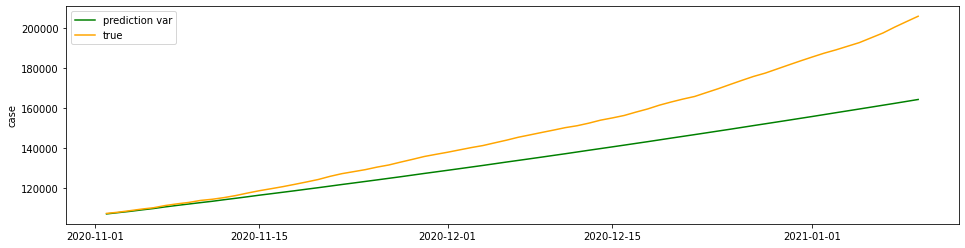

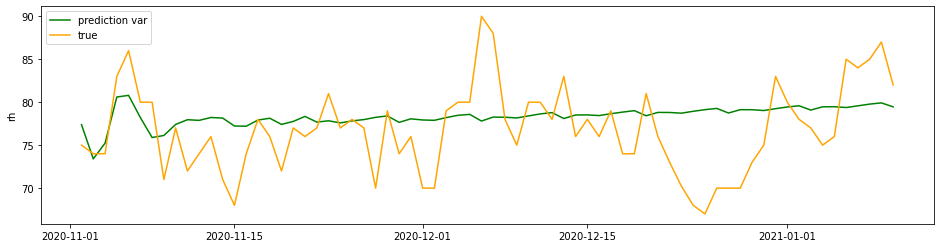

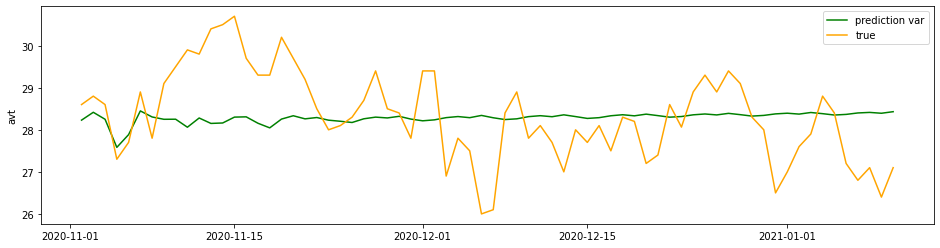

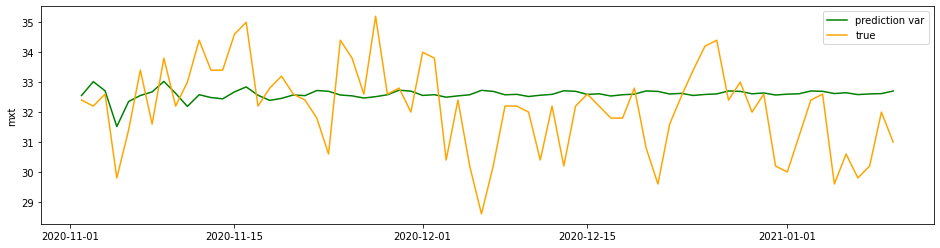

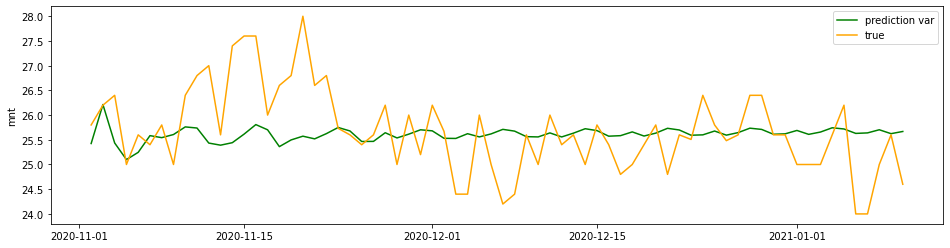

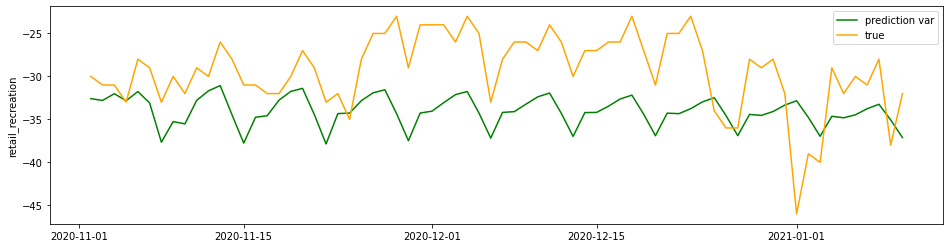

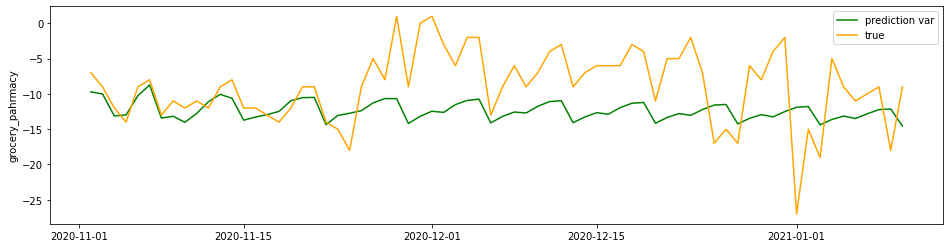

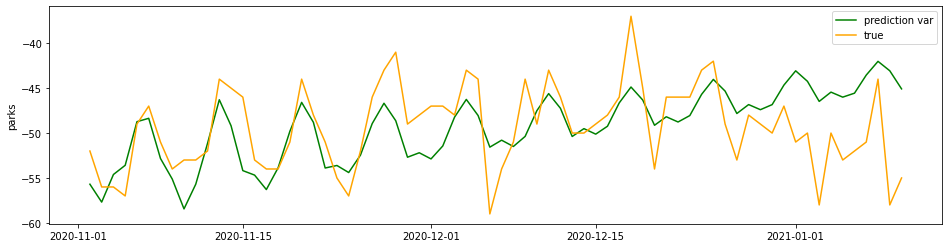

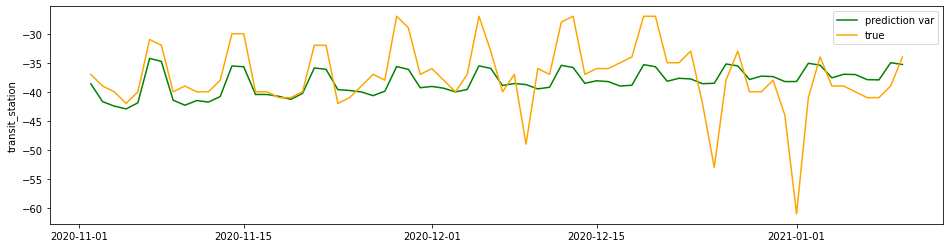

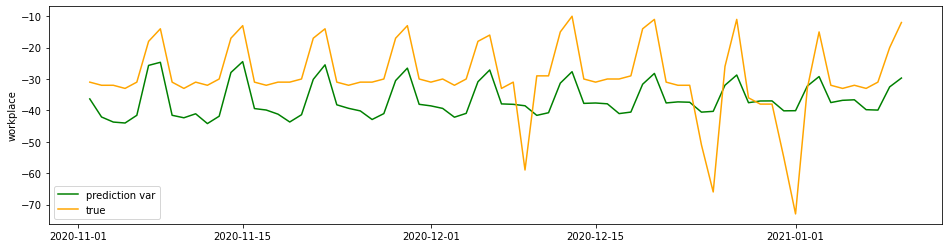

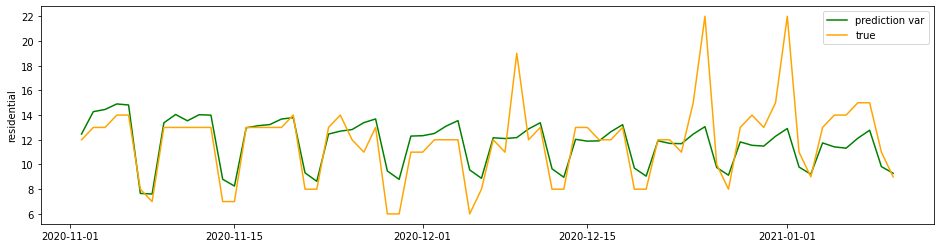

In [50]:
### PLOT ACTUAL vs PREDICTION ###

for i,col in enumerate(df.columns):

    plt.figure(figsize=(16,4))
    plt.plot(date_range, final_pred[:,i], c='green', label='prediction var')
    plt.plot(date_range, final_true[col].values, c='orange', label='true')
    plt.ylabel(col); plt.legend()
    plt.show()

In [51]:
### UTILITY FUNCTIONS FOR NEURAL NETWORK TRAINING ###

def autocor_pred(real, pred, lag=1):
    return pearsonr(real[:-lag], pred[lag:])[0]


seq_length = 30

def get_model():
    
    opt = RMSprop(lr=0.002)
    
    inp = Input(shape=(seq_length, 18))
    
    x = LSTM(64)(inp)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    out = Dense(9)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')
    
    return model

In [52]:
### GET TRAIN VALIDATION AND TEST DATA FOR NEURAL NETWORK ###

X = var_result.fittedvalues

y_train = train.iloc[period+best_order:].values
y_train_var = X + train_init.iloc[best_order:].values
X_train = np.concatenate([train_diff.iloc[best_order:].values, train_ext.iloc[best_order:].values], axis=1)
X_train_var = np.concatenate([X, train_ext.iloc[best_order:].values], axis=1)

y_val = y_train[int(len(X)*0.8):]
y_val_var = y_train_var[int(len(X)*0.8):]
X_val = X_train[int(len(X)*0.8):]
X_val_var = X_train_var[int(len(X)*0.8):]

y_train = y_train[:int(len(X)*0.8)]
y_train_var = y_train_var[:int(len(X)*0.8)]
X_train = X_train[:int(len(X)*0.8)]
X_train_var = X_train_var[:int(len(X)*0.8)]

y_test = test.values
X_test = np.concatenate([test_diff.values, test_ext.values], axis=1)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 236 and the array at index 1 has size 130

In [34]:
### SCALE DATA ###

scaler_y = StandardScaler()
scaler = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_train_var = scaler_y.transform(y_train_var)
y_val = scaler_y.transform(y_val)
y_val_var = scaler_y.transform(y_val_var)
y_test = scaler_y.transform(y_test)

X_train = scaler.fit_transform(X_train)
X_train_var = scaler.transform(X_train_var)
X_val = scaler.transform(X_val)
X_val_var = scaler.transform(X_val_var)
X_test = scaler.transform(X_test)

In [35]:
### BUILD DATA GENERATOR ###

generator_train = TimeseriesGenerator(X_train, y_train, length=seq_length, batch_size=32)
generator_train_var = TimeseriesGenerator(X_train_var, y_train_var, length=seq_length, batch_size=32)
generator_val = TimeseriesGenerator(X_val, y_val, length=seq_length, batch_size=32)
generator_val_var = TimeseriesGenerator(X_val_var, y_val_var, length=seq_length, batch_size=32)
generator_test = TimeseriesGenerator(X_test, y_test, length=seq_length, batch_size=32)

ValueError: `start_index+length=30 > end_index=13` is disallowed, as no part of the sequence would be left to be used as current step.